<a href="https://colab.research.google.com/github/WilliamLu1999/Data-Projects/blob/main/reddit_api_sentiment_analysis_spark.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sentiment Analysis on Reddit's API Charging Policy

### Table of Contents
* [Introduction](#section-1)
* [Ask: Questions, Hypothesis](#section-2)
* [Prepare: Fetch Data](#section-3)
* [Process: Clean Data](#section-4)
* [Analyze: Sentiment Analysis and Visualizations](#section-5)
* [Share: Insights](#section-6)
* [Act: Web Application](#section-7)



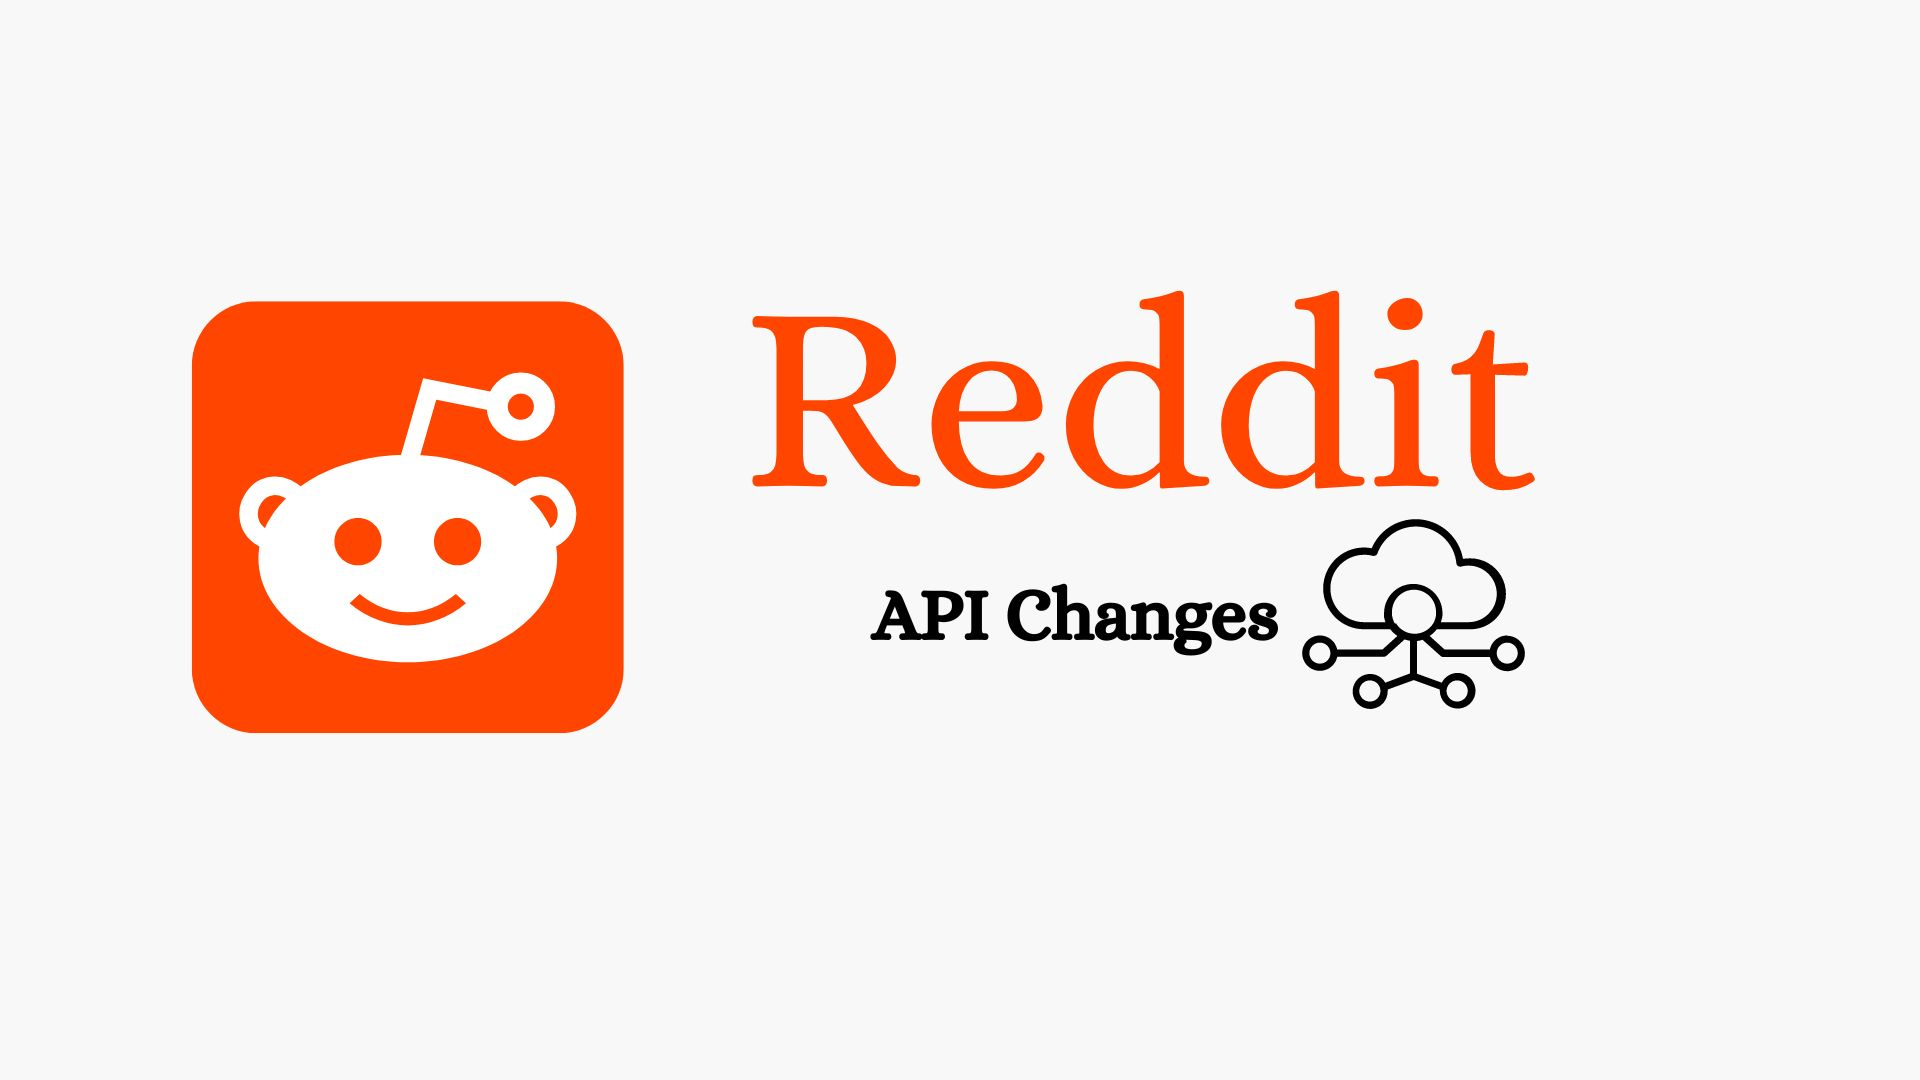


*Retrieved from: https://blogiestools.com/reddit-api-changes/*


<a id="section-1"></a>
### Introduction

*A. Backgroud*


Reddit is one of the biggest social media platforms that consists tons of niches (subreddits), covering a myriad of topics. Users (redditors) can create, share, comment, vote,etc. contents on Reddit.

*B. What happened?*

However, in April 2023, Reddit announced a new policy, which mainly stated that Reddit would start to charge third-party-applications for using its application-programming interface (API). API is a way for two or more computer programs to communicate with each other. It is a type of software interface, offering a service to other pieces of software. <wiki> Reddit's API was free to use since 2005 till 2023.

Now many applications that provide great service by adopting the free use of Reddit's API before are starting to shut down. For example, Apollo ReddPlanet and Sync (both are applications that provide a smooth and beautiful interface for browsing Reddit contents). Besides business shutting down, redditors also protest against this move -- nearly 9,000 subreddits went dark as an act of rebellion starting June 12, some of which with 30 million subscribers.


*C. Why this happened?*

According to Reddit CEO Steve Huffman, big tech companies such as Google, Microsoft, and OpenAI are using Reddit's contents to train LLM and for other AI usage freely. It's unsustainable if Reddit continues not charging any cost for its API.


*D. Souces:*

https://www.entrepreneur.com/business-news/reddit-blackout-protests-explained-api-changes-ceo-and/454629

https://www.zdnet.com/article/reddit-is-in-danger-of-a-death-spiral/


<a id="section-2"></a>
### Ask: Questions, Hypothesis
A. Questions

1.   What are the major sentiments of this topic?
2.   What do people response regards to this problem?
3.   Is it a good move or a bad move for Reddit?
4.   After 2-3 months, will people still be mad? (later after new data are fetched)

B. Hypothesis


1.   Angry and disappointment are the main sentiments of the comments.
2.   People will use them less frequently according to their comments; they will surf other websites as a substitution.
3.   It's in general a bad move at first, but the problem will be sorted out as time goes by since users rely on Reddit too much. Reddit's contents are great in many ways.
4.   Sarcasm in comments occur also quite frequently.




<a id="section-3"></a>
### Prepare: Fetch Data


To fetch the appropriate data, I use the YouTube API, which is free in contrast, to download comments from several videos about Reddit's API charging policy and change.

There are not too many videos about this, and since the issue is still hot so the contents of these may be a bit similar. However, I decide to add more data in the next few months to analyze people's emotions on this issue more.

In [2]:
pip install contractions

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 10.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.8/110.8 kB 9.2 MB/s eta 0:00:00


In [3]:
pip install pyspark


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.8/310.8 MB 4.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.4.1-py2.py3-none-any.whl size=311285398 sha256=6675b398405cefa12283ef8f755a909e374afea583b97508d0cdff710bb50793
  Stored in directory: /root/.cache/pip/wheels/0d/77/a3/ff2f74cc9ab41f8f594dabf0579c2a7c6de920d584206e0834
Successfully built pyspark


In [4]:
from google.colab import drive
drive.mount('/content/drive')

# import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import os
import csv
import seaborn as sns

# import functions for data preprocessing & data preparation
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import resample
from sklearn.feature_extraction.text import CountVectorizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# import for sentiment analysis
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer, LancasterStemmer
from nltk.stem.snowball import SnowballStemmer
from nltk.corpus import stopwords
from nltk.corpus import wordnet
import string
from string import punctuation
import nltk
import re
import contractions
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('vader_lexicon')

# fetch YouTube Data
from googleapiclient.discovery import build

# spark
from pyspark.sql import SparkSession
from pyspark import SparkContext
from pyspark.sql import SQLContext
import pyspark.sql.functions as F
from itertools import combinations
import pyspark
import time
import random
import itertools

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


In [22]:
from googleapiclient.discovery import build
# Youtube API Key is stored in this text file. Not directly using it for safety reason.
with open('/content/drive/MyDrive/data/youtube_API.txt', 'r') as file:
    file_content = file.read()

api_key = str(file_content)


def get_video_comments(video_id):
    youtube = build('youtube', 'v3', developerKey=api_key)

    comments = []
    nextPageToken = None

    while True:
        response = youtube.commentThreads().list(
            part='snippet',
            videoId=video_id,
            maxResults=100,
            pageToken=nextPageToken
        ).execute()

        for item in response['items']:
            comment = item['snippet']['topLevelComment']['snippet']['textDisplay']
            comment_id = item['snippet']['topLevelComment']['id']
            comment_stats = item['snippet']['topLevelComment']['snippet']['likeCount']
            comment_reply_stats = item['snippet']['totalReplyCount']

            comments.append({
                'comment': comment,
                'upvotes': int(comment_stats),
                'downvotes': 0,  # Downvotes are not directly available in commentThreads API
                'replies': int(comment_reply_stats)
            })

        nextPageToken = response.get('nextPageToken')

        if not nextPageToken:
            break

    return comments


# Enter video ID
video_id1 = "Ch6zNEq9fwM"

# Call the function to retrieve comments
comments1 = get_video_comments(video_id1)

In [24]:
# comment out below for future runs
video_id2 = "fBruoybHryU"
comments2 = get_video_comments(video_id2)
video_id3 = "VO-iMK-1ljY"
comments3 = get_video_comments(video_id3)
video_id4 = "vGG_zmcSHJo"
comments4 = get_video_comments(video_id4)
video_id5 = "U06rCBIKM5M"
comments5 = get_video_comments(video_id5)
video_id6 = "nXYOdnn_FLo"
comments6 = get_video_comments(video_id6)
video_id7 = "LxlVe1xwPQc"
comments7 = get_video_comments(video_id7)
video_id8 = 'zL0yFvkLMQc'
comments8 = get_video_comments(video_id8)
video_id9 = 'bXRVRu-qWFU'
comments9 = get_video_comments(video_id9)
video_id10 = 'TEVzqTi_cls'
comments10 = get_video_comments(video_id10)
video_id11 = 'WusFlgO8FX0'
comments11 = get_video_comments(video_id11)

comments = comments1+comments2+comments3+comments4+comments5+comments6+comments7+comments8+comments9+comments10+comments11
# Specify the output CSV file path on Google Drive
csv_file_path = '/content/drive/MyDrive/data/reddit_api_comments.csv'

In [5]:
# transform the list of comments to a dataframe
df = pd.DataFrame(comments)
# store the dataframe as a csv
df.to_csv(csv_file_path,index=False)

NameError: ignored

In [6]:
# run this for every new run
rc = pd.read_csv('/content/drive/MyDrive/data/reddit_api_comments.csv')
rc

,comment,upvotes,downvotes,replies
0,You have to laugh. All those &#39;moderators&...,0.0,0.0,0.0
1,But imagine not using an ad blocker in the yea...,0.0,0.0,0.0
2,The thing about Apollo many people simply don&...,1.0,0.0,0.0
3,Reddit gives you the information you need and ...,0.0,0.0,0.0
4,reddit has fallen,0.0,0.0,0.0
...,...,...,...,...
11950,Gah daymn,0.0,0.0,0.0
11951,Ok,0.0,0.0,0.0
11952,Kinda knew it<br><br><br><br>Edit i am the 3rd,0.0,0.0,0.0
11953,Looks like not enough Redditors assembled,8.0,0.0,0.0


<a id="section-4"></a>
### Process: Clean Data

At the first glance, you see some comments have special charatcers (like the first comment), some have capital letters, and some comments may not deliver any sentiment values (like 'First'). Hence, let's make the comments clean first!




*   Convert all comments to lower letters
*   Remove HTML and urls from comments
*   Remove non-alphabetical characters
*   Perform contractions
*   Remove extra space
*   Remove stop words
*   Perform lemmatization

In [7]:
# find the average comment length before cleaning
rc['comment before'] = rc['comment']
pre_length = rc['comment'].apply(len).mean()
rc['comment'] = rc['comment'].astype(str)
# convert all reviews to lowercase
rc['comment']= rc['comment'].str.lower()
# remove urls from the reviews
rc["comment"] = rc["comment"].str.replace(r'\s*https?://\S+(\s+|$)', '').str.strip()
# remove htmls tag from the reviews
rc['comment'] = rc['comment'].str.replace(r'<[^<>]*>', '', regex=True)
# remove numerics
rc['comment'] = rc['comment'].str.replace('\d+', '',regex=True)
# remove non-alphabetical characters
rc['comment'] = rc['comment'].str.replace('[^a-zA-Z0-9]', ' ', regex=True)
# perform contractions
rc['comment'] = rc['comment'].apply(lambda x: contractions.fix(x))
# remove extra space
rc['comment'] = rc['comment'].str.strip()
stop = nltk.corpus.stopwords.words('english')
rc['comment withno stopwords'] = rc['comment'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
lmtzr = WordNetLemmatizer()
wordnet_map = {"N":wordnet.NOUN,"V":wordnet.VERB,"J":wordnet.ADJ,"R":wordnet.ADV}
# define a lemmatization function and then we can pass in a panda series to perform lemmatization
def lemmatization(series):
    pos_tagged = nltk.pos_tag(series.split())
    return ' '.join([lmtzr.lemmatize(word, wordnet_map.get(pos[0], wordnet.NOUN)) for word, pos in pos_tagged])
rc['comment final'] = rc['comment withno stopwords'].apply(lambda x: lemmatization(x))

<ipython-input-7-ed538066761b>:8: FutureWarning: The default value of regex will change from True to False in a future version.
  rc["comment"] = rc["comment"].str.replace(r'\s*https?://\S+(\s+|$)', '').str.strip()


In [8]:
post_length = rc['comment'].apply(len).mean()
print("Calculating the average comment length......")
print(f"Before cleaning: {pre_length}, after cleaning: {post_length}, length difference: {pre_length-post_length}")
rc.drop(columns = ["comment"])

Calculating the average comment length......
Before cleaning: 154.66976160602258, after cleaning: 149.18519447929737, length difference: 5.48456712672521


,upvotes,downvotes,replies,comment before,comment withno stopwords,comment final
0,0.0,0.0,0.0,You have to laugh. All those &#39;moderators&...,laugh moderators enforce code conduct little f...,laugh moderator enforce code conduct little fi...
1,0.0,0.0,0.0,But imagine not using an ad blocker in the yea...,imagine using ad blocker year,imagine use ad blocker year
2,1.0,0.0,0.0,The thing about Apollo many people simply don&...,thing apollo many people simply realize actual...,thing apollo many people simply realize actual...
3,0.0,0.0,0.0,Reddit gives you the information you need and ...,reddit gives information need wrong time secon...,reddit give information need wrong time second...
4,0.0,0.0,0.0,reddit has fallen,reddit fallen,reddit fallen
...,...,...,...,...,...,...
11950,0.0,0.0,0.0,Gah daymn,gah daymn,gah daymn
11951,0.0,0.0,0.0,Ok,ok,ok
11952,0.0,0.0,0.0,Kinda knew it<br><br><br><br>Edit i am the 3rd,kind knew itedit rd,kind know itedit rd
11953,8.0,0.0,0.0,Looks like not enough Redditors assembled,looks like enough redditors assembled,look like enough redditors assemble


<a id="section-5"></a>
### Analyze: Sentiment Analysis & Visualizations

NLTK's VADER: Assign sentiment score to each comment and classify comments into three categories - positive, negative, and neutral.

In [9]:
# this approach does not consider relationships between words
sentiments = SentimentIntensityAnalyzer()
rc["positive"] = [sentiments.polarity_scores(i)["pos"] for i in rc["comment final"]]
rc["negative"] = [sentiments.polarity_scores(i)["neg"] for i in rc["comment final"]]
rc["neutral"] = [sentiments.polarity_scores(i)["neu"] for i in rc["comment final"]]
rc['compound'] = [sentiments.polarity_scores(i)["compound"] for i in rc["comment final"]]
score = rc["compound"].values
sentiment = []
for i in score:
    if i >= 0.05 :
        sentiment.append('positive')
    elif i <= -0.05 :
        sentiment.append('negative')
    else:
        sentiment.append('neutral')
rc["sentiment"] = sentiment
rc.head()


,comment,upvotes,downvotes,replies,comment before,comment withno stopwords,comment final,positive,negative,neutral,compound,sentiment
0,you have to laugh all those moderators ...,0.0,0.0,0.0,You have to laugh. All those &#39;moderators&...,laugh moderators enforce code conduct little f...,laugh moderator enforce code conduct little fi...,0.129,0.226,0.645,-0.4019,negative
1,but imagine not using an ad blocker in the year,0.0,0.0,0.0,But imagine not using an ad blocker in the yea...,imagine using ad blocker year,imagine use ad blocker year,0.000,0.000,1.000,0.0000,neutral
2,the thing about apollo many people simply don ...,1.0,0.0,0.0,The thing about Apollo many people simply don&...,thing apollo many people simply realize actual...,thing apollo many people simply realize actual...,0.000,0.136,0.864,-0.4588,negative
3,reddit gives you the information you need and ...,0.0,0.0,0.0,Reddit gives you the information you need and ...,reddit gives information need wrong time secon...,reddit give information need wrong time second...,0.000,0.296,0.704,-0.8508,negative
4,reddit has fallen,0.0,0.0,0.0,reddit has fallen,reddit fallen,reddit fallen,0.000,0.714,0.286,-0.3612,negative


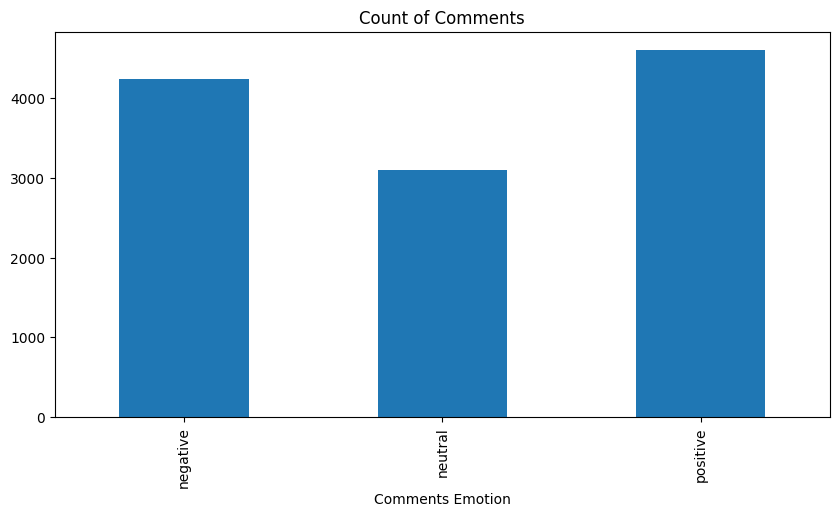

In [10]:
ax = rc['sentiment'].value_counts().sort_index()\
.plot(kind ='bar',title ='Count of Comments',figsize=(10,5))
ax.set_xlabel('Comments Emotion')
plt.show()

In [11]:
print(rc['comment before'][4],sentiments.polarity_scores(rc['comment before'][4]))
# this is a more of a sarcastic comment than a positive comment.
print("I am soo happy!",sentiments.polarity_scores("I am soo happy!"))

reddit has fallen {'neg': 0.556, 'neu': 0.444, 'pos': 0.0, 'compound': -0.3612}
I am soo happy! {'neg': 0.0, 'neu': 0.334, 'pos': 0.666, 'compound': 0.6114}


(0.0, 500.0)

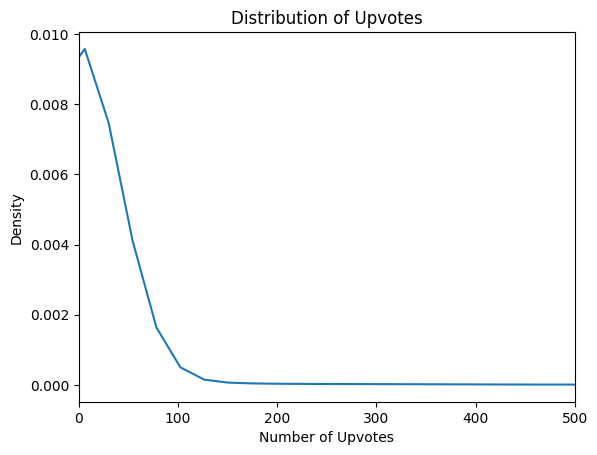

In [12]:
ax2 = rc['upvotes'].plot(kind='kde',title='Distribution of Upvotes')
ax2.set_xlabel('Number of Upvotes')
plt.xlim([0, 500])

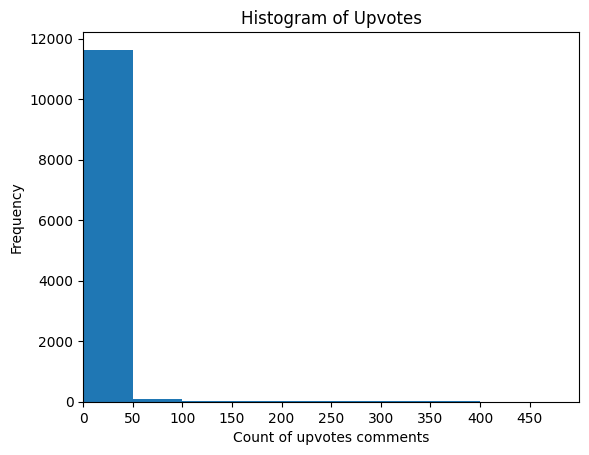

In [13]:
plt.hist(rc['upvotes'], bins=range(int(min(rc['upvotes'])), int(max(rc['upvotes'])) + 2, 50))
# Set the title and axis labels
plt.title('Histogram of Upvotes')
plt.xlabel('Count of upvotes comments')
plt.ylabel('Frequency')
plt.xlim(0,500)
# Display the histogram
plt.xticks(range(0, 500, 50))
plt.show()

Text(0.5, 0.98, 'Compound Scores of Reddit comments Distribution')

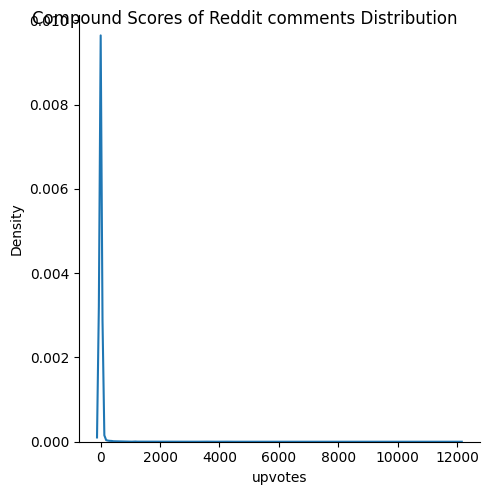

In [14]:
ax3 = sns.displot(data=rc,x='upvotes', kind="kde",legend=False)
ax3.fig.suptitle('Compound Scores of Reddit comments Distribution')

From the above NLTK's VADER results, you can see that there is a high percentage of 'positive' comments for this issue. However, since this issue was not perceived like how I felt on the internet, many so-called positive comments might be sarcastic.

Therefore, we now use ROBERTA transformer model from huggingface. It will consider contexts and may be able to realize if a comment is sarcastic or not.

In [15]:
#pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 102.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 33.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 121.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 44.0 MB/s eta 0:00:00


In [16]:
# perform transfer learning
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from scipy.special import softmax
roberta_tranformer  = f"cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(roberta_tranformer)
roberta = AutoModelForSequenceClassification.from_pretrained(roberta_tranformer)

In [17]:
# run roberta model for all comments
def roberta_polarity(sentence):
  encoded_comment = tokenizer(sentence,return_tensors='pt') # encoding the comment first so that the model will understand
  pred = roberta(**encoded_comment)
  sentiments = pred[0][0].detach().numpy() # make it into numpy so that we can store the results
  sentiments = softmax(sentiments) # softmax it since roberta model does not have the softmax layer
  sentiments_dict = {
      'negative_roberta':sentiments[0],
      'neutral_roberta':sentiments[1],
      'positive_roberta':sentiments[2]
  }
  return sentiments_dict

In [35]:
# getting sentiments scores from a transformer model
roberta_pos =[]
roberta_neg =[]
roberta_neu =[]
for i , row in rc.iterrows():
  try:
    temp = roberta_polarity(row['comment'])
    temp_neg= temp['negative_roberta'] # since the given result is like {}
    temp_pos= temp['positive_roberta']
    temp_neu= temp['neutral_roberta']
    roberta_pos.append(temp_pos)
    roberta_neg.append(temp_neg)
    roberta_neu.append(temp_neu)
  except RuntimeError:
    print(i,temp)
    roberta_pos.append(temp_pos)
    roberta_neg.append(temp_neg)
    roberta_neu.append(temp_neu)
# add these two predicted results to the dataframe
rc['roberta positive'] = roberta_pos
rc['roberta negative'] = roberta_neg
rc['roberta neutral'] = roberta_neu

730 {'negative_roberta': 0.056283593, 'neutral_roberta': 0.30231956, 'positive_roberta': 0.6413969}
1670 {'negative_roberta': 0.6676686, 'neutral_roberta': 0.29347906, 'positive_roberta': 0.038852338}
1791 {'negative_roberta': 0.02320605, 'neutral_roberta': 0.37217686, 'positive_roberta': 0.60461706}
3820 {'negative_roberta': 0.4534665, 'neutral_roberta': 0.44927758, 'positive_roberta': 0.09725594}
4317 {'negative_roberta': 0.947347, 'neutral_roberta': 0.045474257, 'positive_roberta': 0.007178743}
4596 {'negative_roberta': 0.47741276, 'neutral_roberta': 0.4662861, 'positive_roberta': 0.05630119}
5172 {'negative_roberta': 0.8366844, 'neutral_roberta': 0.15020752, 'positive_roberta': 0.01310815}
7293 {'negative_roberta': 0.6501741, 'neutral_roberta': 0.28864762, 'positive_roberta': 0.061178267}
8813 {'negative_roberta': 0.8963766, 'neutral_roberta': 0.09459802, 'positive_roberta': 0.00902526}
10650 {'negative_roberta': 0.39433885, 'neutral_roberta': 0.5642443, 'positive_roberta': 0.04141

Using the transformers pipelines to get sentiments

In [22]:
from transformers import pipeline
transformer_pipeline = pipeline("sentiment-analysis")

No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


Xformers is not installed correctly. If you want to use memory_efficient_attention to accelerate training use the following command to install Xformers
pip install xformers.


In [31]:
sentiment_pipeline =[]
score_pipeline = []
for i , row in rc.iterrows():
  try:
    temp = transformer_pipeline(row['comment'])
    temp_label = temp[0]['label'] # since the given result is like [{,}]
    temp_score = temp[0]['score']
    sentiment_pipeline.append(temp_label)
    score_pipeline.append(temp_score)
  except RuntimeError:
    print(i,temp)
    sentiment_pipeline.append(temp_label)
    score_pipeline.append(temp_score)
# add these two predicted results to the dataframe
rc['sentiment (pipeline)'] = sentiment_pipeline
rc['score (pipeline)'] = score_pipeline

730 [{'label': 'NEGATIVE', 'score': 0.770187497138977}]
1670 [{'label': 'NEGATIVE', 'score': 0.999686598777771}]
1791 [{'label': 'POSITIVE', 'score': 0.9423678517341614}]
4317 [{'label': 'NEGATIVE', 'score': 0.9973094463348389}]
5172 [{'label': 'NEGATIVE', 'score': 0.99741131067276}]
8813 [{'label': 'NEGATIVE', 'score': 0.9995983242988586}]
10650 [{'label': 'NEGATIVE', 'score': 0.9906606078147888}]


In [36]:
rc.head()

,comment,upvotes,downvotes,replies,comment before,comment withno stopwords,comment final,positive,negative,neutral,compound,sentiment,sentiment (pipeline),score (pipeline),roberta positive,roberta negative,roberta neutral
0,you have to laugh all those moderators ...,0.0,0.0,0.0,You have to laugh. All those &#39;moderators&...,laugh moderators enforce code conduct little f...,laugh moderator enforce code conduct little fi...,0.129,0.226,0.645,-0.4019,negative,NEGATIVE,0.998854,0.013057,0.885774,0.101169
1,but imagine not using an ad blocker in the year,0.0,0.0,0.0,But imagine not using an ad blocker in the yea...,imagine using ad blocker year,imagine use ad blocker year,0.000,0.000,1.000,0.0000,neutral,NEGATIVE,0.995783,0.048522,0.445865,0.505613
2,the thing about apollo many people simply don ...,1.0,0.0,0.0,The thing about Apollo many people simply don&...,thing apollo many people simply realize actual...,thing apollo many people simply realize actual...,0.000,0.136,0.864,-0.4588,negative,NEGATIVE,0.999028,0.102981,0.488846,0.408173
3,reddit gives you the information you need and ...,0.0,0.0,0.0,Reddit gives you the information you need and ...,reddit gives information need wrong time secon...,reddit give information need wrong time second...,0.000,0.296,0.704,-0.8508,negative,NEGATIVE,0.999664,0.004738,0.946755,0.048507
4,reddit has fallen,0.0,0.0,0.0,reddit has fallen,reddit fallen,reddit fallen,0.000,0.714,0.286,-0.3612,negative,NEGATIVE,0.999768,0.043507,0.566413,0.390080


In [37]:
# Specify the score output CSV file path on Google Drive
csv_file_path2 = '/content/drive/MyDrive/data/reddit_api_comments+scores.csv'
# transform the list of comments to a dataframe
sentiment_df = pd.DataFrame(rc)
# store the dataframe as a csv
sentiment_df.to_csv(csv_file_path2,index=False)

In [38]:
sentiment_df

,comment,upvotes,downvotes,replies,comment before,comment withno stopwords,comment final,positive,negative,neutral,compound,sentiment,sentiment (pipeline),score (pipeline),roberta positive,roberta negative,roberta neutral
0,you have to laugh all those moderators ...,0.0,0.0,0.0,You have to laugh. All those &#39;moderators&...,laugh moderators enforce code conduct little f...,laugh moderator enforce code conduct little fi...,0.129,0.226,0.645,-0.4019,negative,NEGATIVE,0.998854,0.013057,0.885774,0.101169
1,but imagine not using an ad blocker in the year,0.0,0.0,0.0,But imagine not using an ad blocker in the yea...,imagine using ad blocker year,imagine use ad blocker year,0.000,0.000,1.000,0.0000,neutral,NEGATIVE,0.995783,0.048522,0.445865,0.505613
2,the thing about apollo many people simply don ...,1.0,0.0,0.0,The thing about Apollo many people simply don&...,thing apollo many people simply realize actual...,thing apollo many people simply realize actual...,0.000,0.136,0.864,-0.4588,negative,NEGATIVE,0.999028,0.102981,0.488846,0.408173
3,reddit gives you the information you need and ...,0.0,0.0,0.0,Reddit gives you the information you need and ...,reddit gives information need wrong time secon...,reddit give information need wrong time second...,0.000,0.296,0.704,-0.8508,negative,NEGATIVE,0.999664,0.004738,0.946755,0.048507
4,reddit has fallen,0.0,0.0,0.0,reddit has fallen,reddit fallen,reddit fallen,0.000,0.714,0.286,-0.3612,negative,NEGATIVE,0.999768,0.043507,0.566413,0.390080
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11950,gah daymn,0.0,0.0,0.0,Gah daymn,gah daymn,gah daymn,0.000,0.000,1.000,0.0000,neutral,NEGATIVE,0.952723,0.154145,0.133954,0.711902
11951,ok,0.0,0.0,0.0,Ok,ok,ok,1.000,0.000,0.000,0.2960,positive,POSITIVE,0.999785,0.245824,0.257964,0.496212
11952,kind of knew itedit i am the rd,0.0,0.0,0.0,Kinda knew it<br><br><br><br>Edit i am the 3rd,kind knew itedit rd,kind know itedit rd,0.531,0.000,0.469,0.5267,positive,POSITIVE,0.970147,0.096836,0.120824,0.782340
11953,looks like not enough redditors assembled,8.0,0.0,0.0,Looks like not enough Redditors assembled,looks like enough redditors assembled,look like enough redditors assemble,0.385,0.000,0.615,0.3612,positive,NEGATIVE,0.999762,0.019260,0.732711,0.248029


#### Spark

<a id="section-6"></a>
### Share: Insights


<a id="section-7"></a>
### Act: Web Applications